# Plasma Scattering Matrix Measurement
This notebook aims to illustrate the methodology to measure the plasma/antenna S-matrix of a WEST plasma.

In [357]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Numerical Reference
Before going into the mathematical details and numerical implementation, let's first create a numerical reference antenna. This reference model will serve us to simulate the behaviour of a real antenna when excited by different  power and phase. 

In [358]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
rf.stylely()  # pretty plots
from tqdm.notebook import tqdm
# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

In [359]:
# S-matrix from HFSS non-homogeneous realistic Cold Plasma
Smat_ref = rf.Network('Full_torus_ICLH_plasma_6s_HFSSDesign1.s4p')
Smat_ref

4-Port Network: 'Full_torus_ICLH_plasma_6s_HFSSDesign1',  0.055-0.055 GHz, 1 pts, z0=[46.6303376 +0.j 46.63063457+0.j 46.62013232+0.j 46.6304588 +0.j]

In [360]:
ant_ref = WestIcrhAntenna(frequency=Smat_ref.frequency, front_face=Smat_ref)

Let's find the best capacitor set to match the antenna: 

In [361]:
# perfect dipole excitation
powers = [1e6, 1e6]
phases = [0, np.pi]

In [362]:
C_match = ant_ref.match_both_sides(f_match=55e6, power=powers, phase=phases)

Looking for individual solutions separately for 1st guess...
True solution #1: [58.01033665 49.97464049]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [57.90214819 49.90860857]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [59.73643726 50.15877338 59.69762181 50.20001869]


To verify the matching, let's look at the SWR as seen from the back of the antenna:

In [363]:
ant_ref.vswr_act(powers, phases, Cs=C_match)

array([1.00234395, 1.00167363])

# Problem Description
One WEST ICRH antenna radiating on plasma can be model as the following Figure.

<center><img src="West_Antenna_Simplified_Electric_Model.png" align="center" width="600"/></center>

where:
- $\mathbf{S}^p$ is the plasma/front-face S-parameters
- $\mathbf{S}^{mL}$ and $\mathbf{S}^{mR}$ are the antenna side modules. Capacitors are embedded in these modules, so $\mathbf{S}^{mL}$ depends on $C_1$ and $C_2$ and $\mathbf{S}^{mR}$ depends on $C_3$ and $C_4$ capacitances. In the following, these two modules are supposed to be known (from the electric modelling of the antenna).
- $\mathbf{S}^{ant}$ represents both modules
- $\mathbf{S}^{mes}$ is the S-parameters directly accessible from the RF measurements realized behind the antenna (see after for details)

We have per definition for $\mathbf{S}^{mes}$:
$$
\left(
\begin{array}{c}
b^L \\
b^R
\end{array}
\right)
=
\mathbf{S}^{mes}
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
$$

and for $\mathbf{S}^{p}$
$$
\left(
\begin{array}{c}
b_1 \\
\vdots \\
b_4
\end{array}
\right)
=
\mathbf{b}^p
=
\mathbf{S}^p
\mathbf{a}^p
=
\mathbf{S}^p
\left(
\begin{array}{c}
a_1 \\
\vdots \\
a_4
\end{array}
\right)
$$

and for $\mathbf{S}^{ant}$,
$$
\left(
\begin{array}{c}
b_L \\
b_R \\
\mathbf{a}^p
\end{array}
\right)
=
\mathbf{S}^{ant}
\left(
\begin{array}{c}
a_L \\
a_R \\
\mathbf{b}^p
\end{array}
\right)
$$
as some output waves of the modules are the input waves of the plasma.

With the previous notation, it is convenient to decompose the antenna S-matrix $\mathbf{S}^{ant}$ into 4 submatrices $\mathbf{S}^{ant}_{11}, \mathbf{S}^{ant}_{12}, \mathbf{S}^{ant}_{21}, \mathbf{S}^{ant}_{22}$:
$$
\mathbf{S}^{ant}
=
\left(
\begin{array}{cc}
\mathbf{S}^{ant}_{11} & \mathbf{S}^{ant}_{12} \\
\mathbf{S}^{ant}_{21} & \mathbf{S}^{ant}_{22}
\end{array}
\right)
$$
where:
- $\mathbf{S}^{ant}_{11}$ is of shape (2,2)
- $\mathbf{S}^{ant}_{12}$ is of shape (2,4)
- $\mathbf{S}^{ant}_{21}$ is of shape (4,2) and
- $\mathbf{S}^{ant}_{22}$ is of shape (4,4)

This notation allows to expand the previous definition as:

$$
\left(
    \begin{array}{c}
    b^L \\
    b^R
    \end{array}
\right)
=
\mathbf{S}^{ant}_{11}
\left(
    \begin{array}{c}
    a^L \\
    a^R
    \end{array}
\right)
+
\mathbf{S}^{ant}_{12}
\mathbf{b}^p
$$
and
$$
\mathbf{a}^p
=
\mathbf{S}^{ant}_{21}
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
+
\mathbf{S}^{ant}_{22}
\mathbf{b}^p
$$

Inserting the definition of $S$^p leads to:
$$
\left(
\begin{array}{c}
b^L \\
b^R
\end{array}
\right)
=
\left[
\mathbf{S}^{ant}_{11}
+
\mathbf{S}^{ant}_{12} \mathbf{S}^p 
\left(\mathbf{1} - \mathbf{S}^{ant}_{22} \mathbf{S}^p \right)^{-1} 
\mathbf{S}^{ant}_{21}
\right]
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
$$

which matches the definition of $S^{mes}$, hence by identification:
$$
\boxed{
\mathbf{S}^{mes}
=
\mathbf{S}^{ant}_{11}
+
\mathbf{S}^{ant}_{12} \mathbf{S}^p 
\left(\mathbf{1} - \mathbf{S}^{ant}_{22} \mathbf{S}^p \right)^{-1} 
\mathbf{S}^{ant}_{21}
}
$$

$\mathbf{S}^{mes}$ can be measured using (at least) two different set of antenna excitation, ie. forward waves $(a^L, a^R)$ and associated reflected waves $(b^L, b^R)$: 
$$
\left(
\begin{array}{cc}
b_L^{(1)} & b_L^{(2)}  \\
b_R^{(1)} & b_R^{(2)}  \\
\end{array}
\right)
=
\mathbf{S}^{mes}
\left(
\begin{array}{cc}
a_L^{(1)} & a_L^{(2)}  \\
a_R^{(1)} & a_R^{(2)}  \\
\end{array}
\right)
$$

which leads to:
$$
\mathbf{S}^{mes} 
= 
\left(
\begin{array}{cc}
b_L^{(1)} & b_L^{(2)}  \\
b_R^{(1)} & b_R^{(2)}  \\
\end{array}
\right)
\left(
\begin{array}{cc}
a_L^{(1)} & a_L^{(2)}  \\
a_R^{(1)} & a_R^{(2)}  \\
\end{array}
\right)^{-1}
$$

From the knowledge of $\mathbf{S}^{mes}$, one can deduce $\mathbf{S}^p$:
$$
\boxed{
\mathbf{S}^p
=
\left(
\mathbf{1} + \mathbf{M} \mathbf{S}_{22}^{ant}
\right)^{-1}
\mathbf{M}
}
$$

with:
$$
\mathbf{M}
=
\left(
S_{12}^{ant}
\right)^{-1}
\left(
\mathbf{S}^{mes} - S_{11}^{ant}
\right)
\left(
S_{21}^{ant}
\right)^{-1}
$$
where the inverse of $S_{12}^{ant}$ and $S_{21}^{ant}$ are pseudo-inverse matrices.

# Numerical Test

## Antenna Excitations

Numerical measured quantities behind the antenna $a^{mes}$ and $b^{mes}$ for a set of excitation (power and phase)

In [364]:
# phase scan (constant power)
phases = np.array([[0, np.pi], [0, np.pi - np.pi/10]]) # np.deg2rad(np.array([0, 180])) # dipole + some phase shift
powers = np.array([[1, 1], [1, 1]]) 
_as = []
_bs = []

for power, phase in zip(powers, phases):
    _a = ant_ref.circuit(Cs=C_match)._a_external(power, phase)
    _as.append(_a)
    _bs.append(ant_ref.circuit(Cs=C_match).s_external @ _a)

a_mes = np.array(_as)
b_mes = np.array(_bs).squeeze()

# adding some noise
noise_level = 0e-3
noise_a = noise_level*(np.random.rand(2,2) + 1j*np.random.rand(2,2))
noise_b = noise_level*(np.random.rand(2,2) + 1j*np.random.rand(2,2))
a_mes += noise_a
b_mes += noise_b

print(a_mes.shape, b_mes.shape)

(2, 2) (2, 2)


In [365]:
a_mes

array([[ 1.41421356+0.00000000e+00j, -1.41421356+1.73191211e-16j],
       [ 1.41421356+0.00000000e+00j, -1.34499702+4.37016024e-01j]])

In [366]:
b_mes

array([[-0.00127048-0.00106137j,  0.00096569+0.00068236j],
       [-0.11349094-0.05278951j, -0.1039475 -0.05259523j]])

## Antenna S-matrix

Since we have for $M=2$ measurements 
$$
\mathbf{B}^{mes}
=
\left(
\begin{array}{cc}
b_L^{(1)} & b_L^{(2)}  \\
b_R^{(1)} & b_R^{(2)}  \\
\end{array}
\right)
=
\mathbf{S}^{mes}
\left(
\begin{array}{cc}
a_L^{(1)} & a_L^{(2)}  \\
a_R^{(1)} & a_R^{(2)}  \\
\end{array}
\right)
=
\mathbf{S}^{mes}
\mathbf{A}^{mes}
$$

In [367]:
A_mes = a_mes.T

In [368]:
B_mes = b_mes.T

So, 
$$
\mathbf{S}^{mes} = \mathbf{B}^{mes} \left( \mathbf{A}^{mes} \right)^{-1}
$$

In [369]:
S_mes = B_mes @ np.linalg.inv(A_mes)
S_mes.shape

(2, 2)

In [370]:

V_exp = np.abs(S_mes.squeeze())
V_the = np.abs(ant_ref.circuit(Cs=C_match).network.s.squeeze())

print(V_exp)
print(V_the)

[[0.27915189 0.27927443]
 [0.26592517 0.26593374]]
[[0.27915189 0.27927443]
 [0.26592517 0.26593374]]


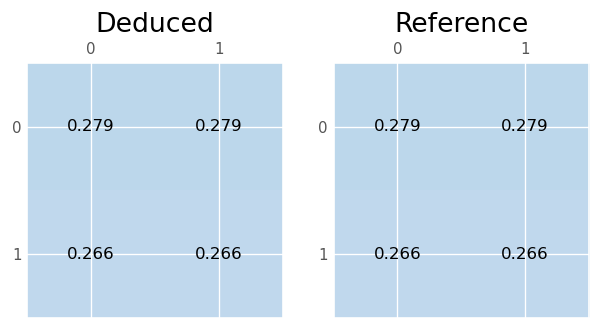

In [405]:
fig, axes = plt.subplots(1,2)

axes[0].matshow(V_exp, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[0].set_title('Deduced')
axes[1].matshow(V_the, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[1].set_title('Reference')
for i in range(2):
    for j in range(2):
        axes[1].text(i, j, f'{V_the[j,i]:.3}', va='center', ha='center')
        axes[0].text(i, j, f'{V_exp[j,i]:.3}', va='center', ha='center')

In [372]:
V_exp2 = np.angle(S_mes.squeeze(), deg=True)
V_the2 = np.angle(ant_ref.circuit(Cs=C_match).network.s.squeeze(), deg=True)

print(V_exp2)
print(V_the2)

[[123.98628175 123.7473884 ]
 [125.7424863  125.92262193]]
[[123.98628175 123.7473884 ]
 [125.7424863  125.92262193]]


It works for the antenna S-matrix !

# Plasma/Front-Face Scattering Parameters - Method 1 from input powers & phases

In [373]:
access = ant_ref._access_circuit(Cs=C_match).network
S_ant = access.s
print(S_ant.shape)

(1, 6, 6)


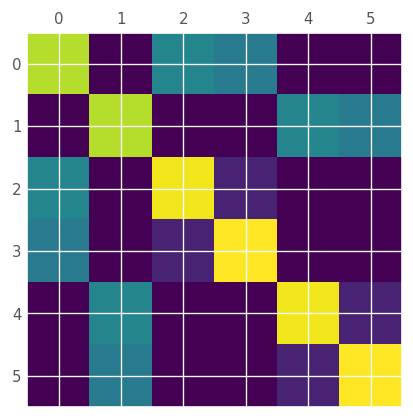

In [374]:
fig, ax = plt.subplots()
ax.matshow(np.abs(S_ant).squeeze())

In [375]:
S_ant11 = S_ant[:,:2,:2].squeeze()
S_ant12 = S_ant[:,:2,2:].squeeze()
S_ant21 = S_ant[:,2:,:2].squeeze()
S_ant22 = S_ant[:,2:,2:].squeeze()

The plasma matrix is:
$$
\mathbf{S}^p
=
\left(
\mathbf{1} + \mathbf{M} \mathbf{S}_{22}^{ant}
\right)^{-1}
\mathbf{M}
$$

In [376]:
M = np.linalg.pinv(S_ant12) @ (S_mes - S_ant11) @ np.linalg.pinv(S_ant21)
M.shape

(4, 4)

In [377]:
S_p = np.linalg.inv(np.eye(len(M)) + M @ S_ant22) @ M
S_p.shape

(4, 4)

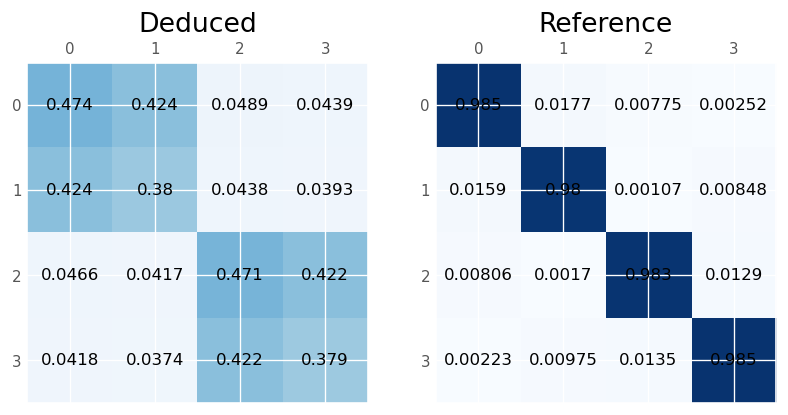

In [378]:
fig, axes = plt.subplots(1,2, figsize=(8,6))
v_exp = np.abs(S_p.squeeze())
v_ref = np.abs(Smat_ref.s.squeeze())

axes[0].matshow(v_exp, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[0].set_title('Deduced')
axes[1].matshow(v_ref, cmap=plt.cm.Blues, vmin=0, vmax=1)       
axes[1].set_title('Reference')
for i in range(4):
    for j in range(4):
        axes[0].text(i, j, f'{v_exp[j,i]:.3}', va='center', ha='center')
        axes[1].text(i, j, f'{v_ref[j,i]:.3}', va='center', ha='center')

It doesn't work!

# Method 2: Using Antenna Voltages

<center><img src="West_Splasma.png" width="300"/></center>

The total voltages are: 

$$\mathbf{V} = \sqrt{Z}\left( \mathbf{a} + \mathbf{b} \right) $$

The plasma S-matrix is defined as (using voltage wave here):

$$
\mathbf{b} = S^p \mathbf{a}
$$



From these two first equations we deduce, for 4 different set of :

$$
\mathbf{a}
=
\mathbf{V}/\sqrt{Z} - \mathbf{b} 
$$

$$
S^p = \mathbf{b} \left(\mathbf{a}\right)^{-1} = \mathbf{b} \left(\mathbf{V}/\sqrt{Z} - \mathbf{b} \right)^{-1}
$$

<center><img src="West_Antenna_Simplified_Electric_Model.png" align="center" width="400"/></center>

The incident voltages on the plasma corresponds to the output voltages of the antenna modules:

$$
\left(
\begin{array}{c}
b_L \\
b_R \\
\mathbf{a}
\end{array}
\right)
= 
S_{ant} 
\left(
\begin{array}{c}
a_L \\
a_R \\
\mathbf{b}
\end{array}
\right)
$$


From this latest equation we deduce:
$$
\mathbf{b} 
= 
\left( S^{ant}_{12} \right)^{-1}
\left[
\left(
\begin{array}{c}
b_L \\
b_R
\end{array}
\right)
- 
S^{ant}_{11}
\left(
\begin{array}{c}
a_L \\
a_R
\end{array}
\right)
\right]
$$

So we can solve for $S^p$

In [379]:
Z = ant_ref.antenna.z0[0][0]

In [398]:
a, b = [], []
_a_mes, _b_mes = [], []
_Vs = []

C_matchs = np.tile(C_match, (N_mes,1)) + np.random.rand(N_mes,4)

for idx, C in enumerate(C_matchs):
    print(C)
    _S_ant = ant_ref._access_circuit(Cs=C).network.s
    _S_ant11 = _S_ant[:,:2,:2].squeeze()
    _S_ant12 = _S_ant[:,:2,2:].squeeze()
    _S_ant21 = _S_ant[:,2:,:2].squeeze()
    _S_ant22 = _S_ant[:,2:,2:].squeeze()

    power = [1, 1]
    phase = [0, np.pi]

    _a_mes = ant_ref.circuit(Cs=list(C))._a_external(power, phase)
    _b_mes = ant_ref.circuit(Cs=list(C)).s_external.squeeze() @ _a_mes
    _V = ant_ref.voltages(power, phase, Cs=list(C)).squeeze()

    _b = np.linalg.pinv(_S_ant12) @ (_b_mes - _S_ant11 @ _a_mes )
    _a = 1/np.sqrt(Z) * _V - _b
   
    a.append(_a)
    b.append(_b)

a = np.array(a).T.squeeze()   
b = np.array(b).T.squeeze()

[60.06541444 50.61714967 59.99561646 50.65526935]
[60.41805948 50.28064176 60.38422816 51.14873672]
[60.10414914 50.82920262 60.21885814 50.55806396]
[59.98212353 50.74017122 60.47799994 50.63227374]


In [399]:
abs(_a)

array([5.21070839, 3.47353071, 4.80217227, 3.17687797])

In [400]:
abs(_b)

array([1.5833484 , 1.42643707, 1.47018945, 1.31624535])

In [401]:
print(f'{a.shape=}')
print(f'{b.shape=}')

a.shape=(4, 4)
b.shape=(4, 4)


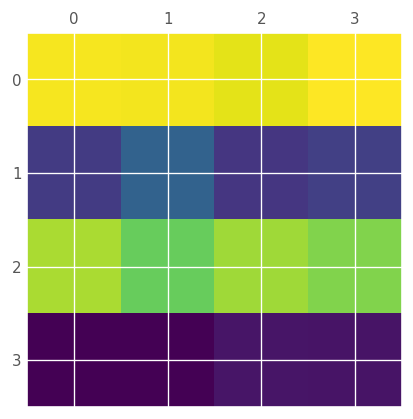

In [415]:
fig, ax = plt.subplots()
ax.matshow(np.abs(a))

In [427]:
Sp_exp = b @ np.linalg.inv(a)
#_dummy = rf.Network(frequency=Smat_ref.frequency, s=Sp_exp)
#_dummy.renumber([0,1,2,3], [0,2,1,3])
#Sp_exp = _dummy.s.squeeze()

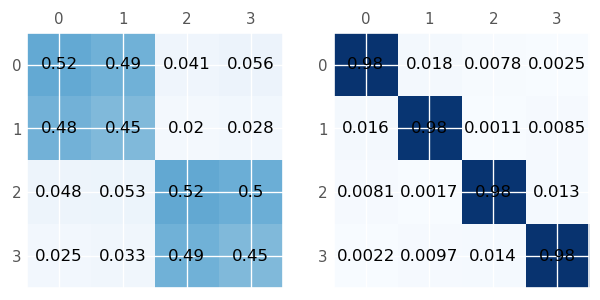

In [428]:
fig, axes = plt.subplots(1,2)
V_exp = np.abs(Sp_exp)
V_the = np.abs(Smat_ref.s.squeeze())
axes[0].matshow(V_exp, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[1].matshow(V_the, cmap=plt.cm.Blues, vmin=0, vmax=1)
for i in range(4):
    for j in range(4):
        axes[0].text(i, j, f'{V_exp[j,i]:.2}', va='center', ha='center')
        axes[1].text(i, j, f'{V_the[j,i]:.2}', va='center', ha='center')

# CSS

In [387]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')